# Shear Stress time series histograms

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').show();
 } else {
 $('div.input').hide();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import math
import subprocess
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import itertools
from susipop import filter
from susipop import reader
from IPython.html.widgets import FloatProgress
from IPython.display import display
from ipywidgets import interactive
import ipywidgets as widgets
import scipy.stats as ss

%matplotlib notebook

import plotly
import susipop as sp
import pylab

import warnings
warnings.filterwarnings('ignore')

/home/vsivadas/.local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
class Stress_distribution_Analysis():
    def __init__(self,path,):
        self.path = path
        self.y = []
        self.exp = reader.DataSet(self.path, fluid=False, particles=True)
        self.exp.load_state(self.exp.tlist[-1])
        self.strain = self.exp.tlist[-1]*self.exp.shearrate*self.exp.dt
        self.range = int(len(self.exp.tlist)/float(self.strain))
    def analyze(self,trange='None'):
        if (trange == 'None') and (self.strain > 1):
            trange =  self.range
        if (self.strain < 1):
            trange = 10
            print "less than one strain"
            
        for t in self.exp.tlist[trange:]:
            self.exp.load_state(t)
            x  = self.exp.particles.sshear_tot
            x = [np.linalg.norm(i) for i in x]
            self.y.extend(x)
    def plot(self,xlim , ylim, bins='fd',scale="linear"):
#         plt.figure()
        hist, bin_edges = np.histogram(np.log10(self.y),bins)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
        hist = hist/float(len(self.y))*100
        plt.step(bin_centers, hist)
        plt.xscale(scale)
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.xlabel("log10 Shear Stresses in particles (Pa)")
        plt.ylabel("Percent of the system in the corresponding State")
        plt.title("Histogram of stresses in "+self.path+" \nover multiple time steps")
        plt.show()


# Plot Stress Distribution in Experiments

# at a timestep

In [24]:
def delete_nan_inf(x):
    nans = len(x) - len(x[~np.isnan(x)])
    x = x[~np.isnan(x)]
    positive_infs = len(x) - len(x[x < 1E308])
    x = x[x < 1E308]
    negative_infs = len(x) - len(x[x > -1E308])
    x = x[x > -1E308]
    print "removed",nans,"nans",  positive_infs,"positive_infs", negative_infs,"negative_infs"
    return x  
def plot_step(x,bins,col,label):
    x = delete_nan_inf(np.log10(x))
    hist, bin_edges = np.histogram((x),bins=bins,normed =True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
    #         histtot = histtot/float(len(sheartot))*100
    plt.plot(bin_centers, hist,color=col,label=label)
def  Stress_distribution_Analysis(phival, shearrate,
                                  sheartot_show, shearlub_show, shearfric_show, shearhd_show,shearrep_show,
                                  xlim, ylim,bins, trange):
    path = "rhor1_phi"+str(phival)+"_yd"+str(float(shearrate))+"/"
    sheartot = []
    shearfric = []
    shearlub = []
    shearhd = []
    shearrep = []
    exp = reader.DataSet(path, fluid=False, particles=True)
    exp.load_state(exp.tlist[-1])
    strain = exp.tlist[-1]*exp.shearrate*exp.dt
    if -1*trange < len(exp.tlist)-1 :
        trange = trange
    else:
        print "trange should be", -1*len(exp.tlist)+1
        trange = -1*len(exp.tlist)+1
    total_datapoints = exp.npart*trange
    for t in [exp.tlist[trange]]:
        exp.load_state(t)
        if sheartot_show:
            x  = exp.particles.sshear_tot
            x = [np.linalg.norm(i) for i in x]
            sheartot.extend(x)
        if shearfric_show:
            x  = exp.particles.sshear_fric
            x = [np.linalg.norm(i) for i in x]
            shearfric.extend(x)
        if shearlub_show:
            x  = exp.particles.sshear_lub
            x = [np.linalg.norm(i) for i in x]
            shearlub.extend(x)
        if shearhd_show:
            x  = exp.particles.sshear_hd
            x = [np.linalg.norm(i) for i in x]
            shearhd.extend(x)
        if shearrep_show:
            x  = exp.particles.sshear_rep
            x = [np.linalg.norm(i) for i in x]
            shearrep.extend(x)
    plt.figure()
    num = len(sheartot)
    if sheartot_show:
        print "sheartot"
        plot_step(sheartot,bins,'k',"tot")
    if shearfric_show:
        print "shearfric"
        plot_step(shearfric,bins,'r',"fric")

    if shearlub_show:
        print "shearlub"
        plot_step(shearlub,bins,'b',"lub")

    if shearhd_show:
        print "shearhd"
        plot_step(shearhd,bins,'g',"hd")

    if shearrep_show:
        print "shearrep"
        plot_step(shearrep,bins,'c',"rep")


    plt.xscale("linear")
    plt.xlim(xlim)
#     plt.ylim(ylim)
    plt.xlabel("log10 Shear Stresses in particles (Pa)")
    plt.ylabel("normalized stress distribution")
#     plt.title("Histogram of stresses in "+path+" \nover multiple time steps")
    plt.suptitle("$\phi=$"+str(phival) + " $\dot{\gammma}=$"+str(shearrate))
#     mpl.rcParams.update({'font.size': 20})
    plt.legend(loc = "best")
    plt.show()



v = interactive(Stress_distribution_Analysis, \
                phival = widgets.ToggleButtons(options=[40,45,50,54,55,56,58],value=56,disabled=False), \
                shearrate= widgets.ToggleButtons(options=[1,10,11,11.5,12,12.5,13,14,15,16,18,20,30,50,70,100,200,300,1000],value = 12),\
                xlim = widgets.FloatRangeSlider(min = -10, max = 10,step=1, value = [-3,5]),
                ylim = widgets.FloatRangeSlider(min = 0, max = 20, value = [0,15]),
                sheartot_show = widgets.ToggleButton(value=True),
                shearlub_show = widgets.ToggleButton(value=False),
                shearfric_show = widgets.ToggleButton(value=False),
                shearhd_show = widgets.ToggleButton(value=False),
                shearrep_show = widgets.ToggleButton(value=False),
                bins=widgets.IntSlider(min=10,max = 150, value = 80),
                trange = widgets.IntSlider(min = -1000, max = -1,step=-1, value = -50), __manual=True)

display(v)

# averaged over multiple timesteps

In [23]:
def delete_nan_inf(x):
    nans = len(x) - len(x[~np.isnan(x)])
    x = x[~np.isnan(x)]
    positive_infs = len(x) - len(x[x < 1E308])
    x = x[x < 1E308]
    negative_infs = len(x) - len(x[x > -1E308])
    x = x[x > -1E308]
    print "removed",nans,"nans",  positive_infs,"positive_infs", negative_infs,"negative_infs"
    return x  
def plot_step(x,bins,col,label):
    x = delete_nan_inf(np.log10(x))
    hist, bin_edges = np.histogram((x),bins=bins,normed =True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
    #         histtot = histtot/float(len(sheartot))*100
    plt.plot(bin_centers, hist,color=col,label=label)
def  Stress_distribution_Analysis(phival, shearrate,
                                  sheartot_show, shearlub_show, shearfric_show, shearhd_show,shearrep_show,
                                  xlim, ylim,bins, trange):
    path = "rhor1_phi"+str(phival)+"_yd"+str(float(shearrate))+"/"
    sheartot = []
    shearfric = []
    shearlub = []
    shearhd = []
    shearrep = []
    exp = reader.DataSet(path, fluid=False, particles=True)
    exp.load_state(exp.tlist[-1])
    strain = exp.tlist[-1]*exp.shearrate*exp.dt
    if -1*trange < len(exp.tlist)-1 :
        trange = trange
    else:
        print "trange should be", -1*len(exp.tlist)+1
        trange = -1*len(exp.tlist)+1
    total_datapoints = exp.npart*trange
    for t in exp.tlist[trange:]:
        exp.load_state(t)
        if sheartot_show:
            x  = exp.particles.sshear_tot
            x = [np.linalg.norm(i) for i in x]
            sheartot.extend(x)
        if shearfric_show:
            x  = exp.particles.sshear_fric
            x = [np.linalg.norm(i) for i in x]
            shearfric.extend(x)
        if shearlub_show:
            x  = exp.particles.sshear_lub
            x = [np.linalg.norm(i) for i in x]
            shearlub.extend(x)
        if shearhd_show:
            x  = exp.particles.sshear_hd
            x = [np.linalg.norm(i) for i in x]
            shearhd.extend(x)
        if shearrep_show:
            x  = exp.particles.sshear_rep
            x = [np.linalg.norm(i) for i in x]
            shearrep.extend(x)
    plt.figure()
    num = len(sheartot)
    if sheartot_show:
        print "sheartot"
        plot_step(sheartot,bins,'k',"tot")
    if shearfric_show:
        print "shearfric"
        plot_step(shearfric,bins,'r',"fric")

    if shearlub_show:
        print "shearlub"
        plot_step(shearlub,bins,'b',"lub")

    if shearhd_show:
        print "shearhd"
        plot_step(shearhd,bins,'g',"hd")

    if shearrep_show:
        print "shearrep"
        plot_step(shearrep,bins,'c',"rep")


    plt.xscale("linear")
    plt.xlim(xlim)
#     plt.ylim(ylim)
    plt.xlabel("log10 Shear Stresses in particles (Pa)")
    plt.ylabel("normalized stress distribution")
#     plt.title("Histogram of stresses in "+path+" \nover multiple time steps")
    plt.suptitle("$\phi=$"+str(phival) + " $\dot{\gammma}=$"+str(shearrate))
#     mpl.rcParams.update({'font.size': 20})
    plt.legend(loc = "best")
    plt.show()



v = interactive(Stress_distribution_Analysis, \
                phival = widgets.ToggleButtons(options=[40,45,50,54,55,56,58],value=56,disabled=False), \
                shearrate= widgets.ToggleButtons(options=[1,10,11,11.5,12,12.5,13,14,15,16,18,20,30,50,70,100,200,300,1000],value = 12),\
                xlim = widgets.FloatRangeSlider(min = -10, max = 10,step=1, value = [-3,5]),
                ylim = widgets.FloatRangeSlider(min = 0, max = 20, value = [0,15]),
                sheartot_show = widgets.ToggleButton(value=True),
                shearlub_show = widgets.ToggleButton(value=False),
                shearfric_show = widgets.ToggleButton(value=False),
                shearhd_show = widgets.ToggleButton(value=False),
                shearrep_show = widgets.ToggleButton(value=False),
                bins=widgets.IntSlider(min=10,max = 150, value = 80),
                trange = widgets.IntSlider(min = -1000, max = -1,step=-1, value = -50), __manual=True)

display(v)

# Compare Stress Distribution

<IPython.core.display.Javascript object>


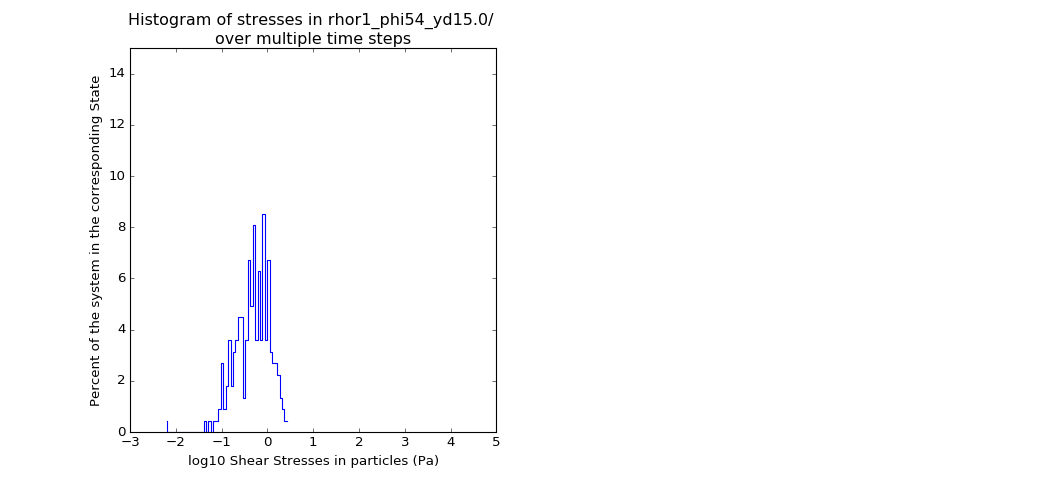

trange should be -201 . Trange reset to maximum value


In [5]:

def  Stress_distribution_Analysis(phival, ydvals, xlim, ylim,bins, trange):
    plt.figure(figsize=[13,6*(len(ydvals)+len(ydvals)%2)/2])
    plt.title("phival = "+str(phival))
    j = len(ydvals)
    for i,shearrate in enumerate(ydvals):
        try:
            plt.subplot(int(j/2.0)+1,2,i+1)
            path = "rhor1_phi"+str(phival)+"_yd"+str(float(shearrate))+"/"
            exp = reader.DataSet("rhor1_phi"+str(phival)+"_yd"+str(float(shearrate)))
            if -1*trange < len(exp.tlist)-1 :
                trange = trange
            else:
                trange = -1*(len(exp.tlist)-1)
            print "trange should be", -1*len(exp.tlist)+1 , ". Trange reset to maximum value"
            sheartot = []
            exp.load_state(exp.tlist[-1])
            strain = exp.tlist[-1]*exp.shearrate*exp.dt
        #     srange = int(len(exp.tlist)/float(strain))
        #     if (trange == 'None') and (self.strain > 1):
        #         trange =  srange
        #     if (strain < 1):
        #         trange = 10
        #         print "less than one strain"
            if -1*trange < len(exp.tlist)-1 :
                for t in exp.tlist[trange:]:
                    exp.load_state(t)
                    x  = exp.particles.sshear_tot
                    x = [np.linalg.norm(i) for i in x]
                    sheartot.extend(x)
                hist, bin_edges = np.histogram(np.log10(sheartot),bins=bins,,normed =True)
                bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
                hist = hist/float(len(sheartot))*100
                plt.step(bin_centers, hist)
                plt.xscale("linear")
                plt.xlim(xlim)
                plt.ylim(ylim)
                plt.xlabel("log10 Shear Stresses in particles (Pa)")
                plt.ylabel("Percent of the system in the corresponding State")
                plt.title("Histogram of stresses in "+path+" \nover multiple time steps")
                plt.show()
            
        except Exception as e:
            print e
            continue

        


v = interactive(Stress_distribution_Analysis, \
                phival = widgets.ToggleButtons(options=[40,45,50,54,55,56,58],value=56,disabled=False), \
                ydvals= widgets.SelectMultiple(options=[1,10,11,11.5,12,12.5,13,14,15,16,18,20,30,50,70,100,200,300,1000]),\
                xlim = widgets.FloatRangeSlider(min = -10, max = 10,step=1, value = [-3,5]),
                ylim = widgets.FloatRangeSlider(min = 0, max = 20, value = [0,15]),
                bins=(10,100),
                trange = widgets.IntSlider(min = -1000, max = -1,step=-1, value = -1), __manual=True)

display(v)

In [6]:
caption = widgets.Label(value='The values of range1 and range2 are synchronized')
slider = widgets.IntSlider(min=-5, max=5, value=1, description='Slider')

def handle_slider_change(change):
    caption.value = 'The slider value is ' + (
        'negative' if change.new < 0 else 'nonnegative'
    )

slider.observe(handle_slider_change, names='value')

display(caption, slider)